# Experimentacion - AGREGANDO DATA EXTERNA

## Modelo - Ubicacion (Latitud y Longitud, Continente)

### Voy a experimentar con las caracterisiticas principales de los paises, como su ubicacion, su status, su capacidad de gasto. Todo ese tipo de atributos que lo encasillan en una etiqueta en particular. La zona donde se ubica un pais puede explicar varias cosas sobre el. Si pensamos en un pais ubicado en el hemisferio norte del mundo, es probable que demos con uno desarrollado. Mientras que si, por ejemplo, pensamos en un pais ubicado en Africa, es probable que su expectativa de vida sea menor a la media. Vamos a ver como esto se condice con los datos y el analisis de regresion.

### Importo todos los modulos, funciones y datasets que me son de ayuda para la experimentacion

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence as influence

def rmse(fitted, target):
    rmse = np.sqrt(mean_squared_error(target, fitted))
    return rmse

def adjusted_r2(p, fitted, target):
    n=len(target)
    return 1 - (1-r2_score(target, fitted)) * (n-1) / (n-p-1)

def standarized_residual_plot(predicted, actual):
    residuals = actual - predicted
    standarized_residuals = residuals/np.std(residuals)
    plt.scatter(predicted, standarized_residuals)
    plt.xlabel("Predicciones")
    plt.ylabel("Residuos standarizados")
    plt.hlines(0, xmin=min(predicted), xmax=max(predicted))
    plt.title("Residuos standarizados")
    return standarized_residuals

def ols_influence(lm):
    plt.figure(figsize=(30,30))
    sm.graphics.influence_plot(lm, alpha  = 0.05, criterion="cooks")
    plt.show()

    
def run_analysis(predictors, dataset):
    target = dataset['Life expectancy']
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    if len(predictors)>1:
        for i in range(0, len(predictors)):
            print(f"VIF for {predictors[i]} {variance_inflation_factor(features, i)}")

    features = sm.add_constant(features)
    regr = sm.OLS(target, features).fit()
    fitted = regr.predict(features)
    print(regr.summary())
    standarized_residuals = standarized_residual_plot(fitted, target)
    ols_influence(regr)
    #sm.qqplot(regr.resid)
    plt.figure()
    plt.hist(regr.resid)
    plt.show()
    return {
        'model': regr,
        'r2':r2_score(target, fitted),
        'rmse':rmse(fitted, target),
        'adjusted':adjusted_r2(p, fitted, target),
        'standarized_residuals': standarized_residuals,
        'fitted': fitted
    }

# Me da los residuos estandarizados
def residuos(predictors, dataset):
    target = dataset['Life expectancy']
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    if len(predictors)>1:
        for i in range(0, len(predictors)):
            print(f"VIF for {predictors[i]} {variance_inflation_factor(features, i)}")

    features = sm.add_constant(features)
    regr = sm.OLS(target, features).fit()
    fitted = regr.predict(features)
    standarized_residuals = standarized_residual_plot(fitted, target)
    return np.array(standarized_residuals)


# Me da la distancia de Cook de cada pais
def cooksDist(predictors, dataset):
    target = dataset['Life expectancy']
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    if len(predictors)>1:
        for i in range(0, len(predictors)):
            print(f"VIF for {predictors[i]} {variance_inflation_factor(features, i)}")

    features = sm.add_constant(features)
    regr = sm.OLS(target, features).fit()
    inf = influence(regr)
    # cooks_distance is an attribute of incluence, here C, not sure about P (p-value maybe?)
    C, P = inf.cooks_distance
    return C, P

# Me da el Leverage de cada pais
def getLeverage(predictors, dataset):
    target = dataset['Life expectancy']
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    if len(predictors)>1:
        for i in range(0, len(predictors)):
            print(f"VIF for {predictors[i]} {variance_inflation_factor(features, i)}")

    features = sm.add_constant(features)
    regr = sm.OLS(target, features).fit()
    inf = influence(regr)
    leverage = inf.hat_matrix_diag
    return leverage


df_exp = pd.read_csv("expectativa_de_vida.csv")
df_coord = pd.read_csv("average-latitude-longitude-countries.csv")

### Armo el data set con la ubicacion en el mapa de cada pais (como se realiza en el archivo 'Mapa.ipynb')

In [29]:
paises = []
nombres1 = df_exp["Country"].tolist()
nombres2 = df_coord["Country"].tolist()

from difflib import SequenceMatcher

for i in range(len(nombres1)):
    n1 = nombres1[i]
    
    conSubstringsEnComun = []
    
    for j in range(len(nombres2)):
        n2 = nombres2[j]
        seq = SequenceMatcher(None, n1, n2)
        match = seq.find_longest_match(0,len(n1),0,len(n2))
        
        """
        if ((match[2] == len(n1)) or (match[2] == len(n2))):
            r = seq.ratio()
            conSubstringsEnComun.append([r,n1,n2])
        """
        r = seq.ratio()
        
        if ((match[2] == len(n1)) or (match[2] == len(n2)) or (match[2] > 3 and r>0.6)):
            conSubstringsEnComun.append([r,n1,n2])
        
    conSubstringsEnComun.sort()
    conSubstringsEnComun.reverse()
    
    
    if (len(conSubstringsEnComun) > 0):
        paises.append([conSubstringsEnComun[0][1], conSubstringsEnComun[0][2]])
    else:
        paises.append(n1)

In [30]:
df = df_exp
latitudes = []
longitudes = []

for i in range(len(paises)):
    lat = df_coord[df_coord["Country"]==paises[i][1]]["Latitude"].values
    long = df_coord[df_coord["Country"]==paises[i][1]]["Longitude"].values
    if len(lat) > 0:
        lat = lat[0]
        long = long[0]
    else:
        lat = 0
        long = 0
    latitudes.append(lat)
    longitudes.append(long)

df["Latitude"] = latitudes
df["Longitude"] = longitudes

In [31]:
df['Status_Float'] = df['Status'].apply(lambda x: 0 if x=='Developing' else 1)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       183 non-null    int64  
 1   Country                          183 non-null    object 
 2   Life expectancy                  183 non-null    float64
 3   Adult Mortality                  183 non-null    float64
 4   infant deaths                    183 non-null    float64
 5   Alcohol                          182 non-null    float64
 6   percentage expenditure           183 non-null    float64
 7   Hepatitis B                      174 non-null    float64
 8   Measles                          183 non-null    float64
 9   BMI                              181 non-null    float64
 10  under-five deaths                183 non-null    float64
 11  Polio                            183 non-null    float64
 12  Total expenditure     

### Ahora agrego la zona donde se encuentra cada Estado

In [33]:
df_zona = pd.read_csv("country-and-continent-codes-list.csv")

In [34]:
df_zona.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Continent_Name             262 non-null    object 
 1   Continent_Code             219 non-null    object 
 2   Country_Name               262 non-null    object 
 3   Two_Letter_Country_Code    261 non-null    object 
 4   Three_Letter_Country_Code  258 non-null    object 
 5   Country_Number             258 non-null    float64
dtypes: float64(1), object(5)
memory usage: 12.4+ KB


### Equivalencia entre paises

In [35]:
paises = []
nombres1 = df["Country"].tolist()
nombres2 = df_zona["Country_Name"].tolist()

for i in range(len(nombres1)):
    n1 = nombres1[i]
    
    conSubstringsEnComun = []
    
    for j in range(len(nombres2)):
        n2 = nombres2[j]
        seq = SequenceMatcher(None, n1, n2)
        match = seq.find_longest_match(0,len(n1),0,len(n2))
        
        """
        if ((match[2] == len(n1)) or (match[2] == len(n2))):
            r = seq.ratio()
            conSubstringsEnComun.append([r,n1,n2])
        """
        r = seq.ratio()
        
        if ((match[2] == len(n1)) or (match[2] == len(n2)) or (match[2] > 3 and r>0.6)):
            conSubstringsEnComun.append([r,n1,n2])
        
    conSubstringsEnComun.sort()
    conSubstringsEnComun.reverse()
    
    
    if (len(conSubstringsEnComun) > 0):
        paises.append([conSubstringsEnComun[0][1], conSubstringsEnComun[0][2]])
    else:
        paises.append(n1)

In [36]:
df_new = df
zonas = []

for i in range(len(paises)):
    zone = df_zona[df_zona["Country_Name"]==paises[i][1]]["Continent_Name"].values
    if len(zone) > 0:
        zone = zone[0]
    else:
        zone = 'null'
    zonas.append(zone)

df_new["Continente"] = zonas

In [42]:
df_new["Continente"]

0               Asia
1             Europe
2             Africa
3               Asia
4      North America
           ...      
178    South America
179             null
180             Asia
181           Africa
182           Africa
Name: Continente, Length: 183, dtype: object

### Veo aquellos paises que quedaron sin zona y los completamos

In [37]:
df_new[df_new["Continente"] == 'null']

,Unnamed: 0,Country,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status,Latitude,Longitude,Status_Float,Continente
19,19,Bolivia (Plurinational State of),67.70625,177.5000,10.7500,3.212000,0.000000,82.875000,7.6250,44.81875,...,NaN,1.30000,1.1875,0.633750,13.9625,Developing,-17.0,-65.0,0,null
27,27,Cabo Verde,72.51875,116.1875,0.0000,3.448000,188.632987,80.642857,0.1250,24.37500,...,292600.25,8.01250,7.9750,0.570000,12.2000,Developing,16.0,-24.0,0,null
42,43,Czechia,76.76875,71.8125,0.0000,13.026000,0.000000,97.285714,22.9375,55.71250,...,NaN,1.99375,2.0625,NaN,NaN,Developed,0.0,0.0,1,null
88,90,Kyrgyzstan,69.08125,173.6875,3.7500,2.267333,0.000000,85.562500,1156.6250,35.11250,...,NaN,3.35625,3.4125,0.622063,12.3375,Developing,41.0,75.0,0,null
179,189,Viet Nam,74.77500,126.5625,29.1875,3.087333,0.000000,87.538462,4232.9375,11.18750,...,NaN,14.92500,15.6250,0.627063,11.5125,Developing,16.0,106.0,0,null


### Les asigno sus respectivos continentes

In [43]:
df_new.loc[19, 'Continente'] = 'South America' #Bolivia
df_new.loc[27, 'Continente'] = 'Africa' #Cabo Verde
df_new.loc[42, 'Continente'] = 'Europe' #Czechia
df_new.loc[88, 'Continente'] = 'Asia' # Kyrgyzstan
df_new.loc[179, 'Continente'] = 'Asia' #Viet Nam

In [45]:
df_new[df_new['Country'] == 'Bolivia (Plurinational State of)']['Continente'] 

19    South America
Name: Continente, dtype: object

### Vemos como se compara la expectativa de vida en cada region siendo un pais desarrollado o sub-desarrollado

<AxesSubplot:xlabel='Continente', ylabel='Life expectancy'>

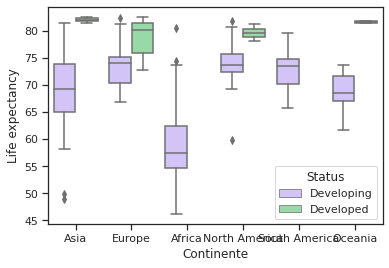

In [54]:
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(x="Continente", y="Life expectancy",
            hue="Status", palette=["m", "g"],
            data=df_new)

### Le agrego valor numerico a los continentes

In [65]:
df_new[df_new["Country"] == 'Argentina']["Continente"].values[0]

'South America'

In [70]:
continentes = []
countries = df['Country']

for i in range(len(countries)):
    cont = df_new[df_new["Country"] == countries[i]]["Continente"].values
    if len(cont) > 0:
        cont = cont[0]
        if cont == 'Africa':
            cont = 0
        elif cont == 'Asia': 
            cont = 1 
        elif cont == 'South America':
            cont = 2 
        elif cont == 'North America': 
            cont = 3 
        elif cont == 'Oceania':
            cont = 4 
        elif cont == 'Europe':
            cont = 5
        
    else:
        cont = -1
    continentes.append(cont)

df_new["Continente_Nro"] = continentes

In [75]:
df_new.corr()['Continente_Nro']

Unnamed: 0                        -0.033727
Life expectancy                    0.652746
Adult Mortality                   -0.550071
infant deaths                     -0.186443
Alcohol                            0.640571
percentage expenditure             0.429690
Hepatitis B                        0.184245
Measles                           -0.204647
BMI                                0.731121
under-five deaths                 -0.198875
Polio                              0.410837
Total expenditure                  0.422968
Diphtheria                         0.406470
HIV/AIDS                          -0.364967
GDP                                0.428181
Population                        -0.077632
thinness  1-19 years              -0.615603
thinness 5-9 years                -0.606105
Income composition of resources    0.584496
Schooling                          0.628131
Latitude                           0.502346
Longitude                         -0.127667
Status_Float                    

In [76]:
df_new.corr()['Life expectancy']

Unnamed: 0                        -0.017423
Life expectancy                    1.000000
Adult Mortality                   -0.896441
infant deaths                     -0.199914
Alcohol                            0.461720
percentage expenditure             0.524320
Hepatitis B                        0.429536
Measles                           -0.201076
BMI                                0.723824
under-five deaths                 -0.225785
Polio                              0.679231
Total expenditure                  0.290713
Diphtheria                         0.672322
HIV/AIDS                          -0.587153
GDP                                0.611808
Population                        -0.039915
thinness  1-19 years              -0.523989
thinness 5-9 years                -0.515970
Income composition of resources    0.817545
Schooling                          0.794457
Latitude                           0.471175
Longitude                         -0.098699
Status_Float                    

### Sabiendo las coordenadas de cada pais, analizamos como estas infieren en su expectativa de vida

VIF for Latitude 1.0437650861009335
VIF for Longitude 1.0437650861009335
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     27.76
Date:                Tue, 09 Nov 2021   Prob (F-statistic):           3.12e-11
Time:                        17:55:25   Log-Likelihood:                -640.41
No. Observations:                 183   AIC:                             1287.
Df Residuals:                     180   BIC:                             1296.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

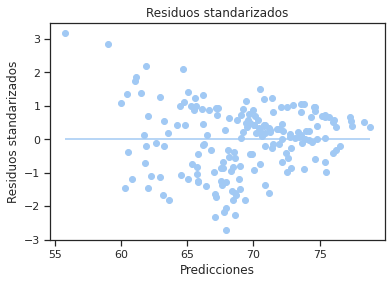

<Figure size 2160x2160 with 0 Axes>

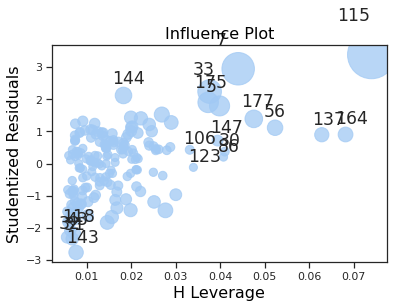

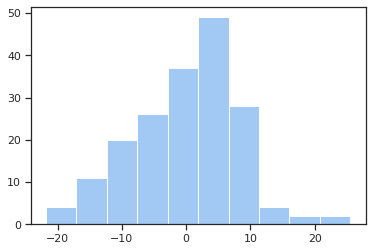

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fd93ff6af40>,
 'r2': 0.235703390469284,
 'rmse': 8.009178403974595,
 'adjusted': 0.22721120591894284,
 'standarized_residuals': 0     -1.616090
 1      0.224940
 2      0.293656
 3     -1.821969
 4      0.586737
          ...   
 178    0.575885
 179    0.927827
 180   -0.533636
 181   -1.130594
 182   -1.443459
 Name: Life expectancy, Length: 183, dtype: float64,
 'fitted': array([71.13729937, 73.35466208, 71.26680619, 63.61122223, 70.35697096,
        61.07265077, 72.75172118, 59.03844238, 74.62261725, 72.80098217,
        71.91039014, 70.10211862, 69.07362415, 69.61034711, 75.41125185,
        75.4185628 , 70.84662565, 67.90146854, 69.70428844, 64.19352518,
        73.93606538, 61.78412342, 65.30352807, 65.09828374, 73.63577584,
        68.61199915, 65.06118776, 69.52968173, 66.812905  , 67.09846112,
        78.75751197, 67.12972724, 68.62408949, 61.92071568, 70.82992439,
        68.14565052, 63.23851795, 

In [56]:
run_analysis(['Latitude', 'Longitude'], df_new)

### Por lo pronto no hay un valor considerable en el ajuste. Y si anadimos su status? Nos proveera mas informacion esto?

### Agregamos el estado de un pais

VIF for Latitude 1.4933713728428735
VIF for Longitude 1.0452640220137241
VIF for Status_Float 1.4617368617754973
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     31.73
Date:                Tue, 09 Nov 2021   Prob (F-statistic):           1.70e-16
Time:                        17:55:39   Log-Likelihood:                -625.99
No. Observations:                 183   AIC:                             1260.
Df Residuals:                     179   BIC:                             1273.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

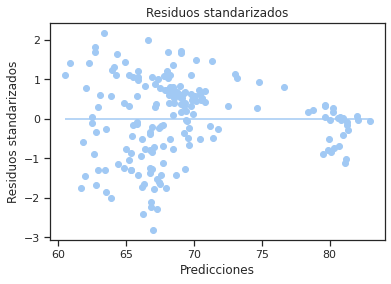

<Figure size 2160x2160 with 0 Axes>

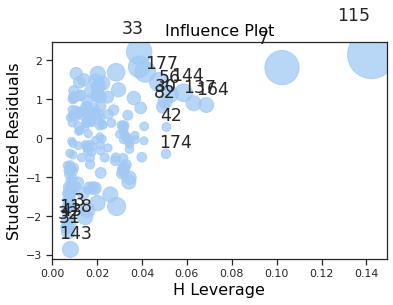

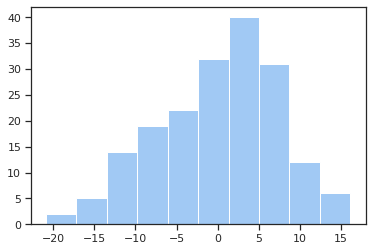

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fd94026a730>,
 'r2': 0.34717406193386036,
 'rmse': 7.402112849371557,
 'adjusted': 0.33623284509476303,
 'standarized_residuals': 0     -1.414891
 1      0.638174
 2      0.605315
 3     -2.011736
 4      0.827641
          ...   
 178    0.741943
 179    1.203079
 180   -0.391527
 181   -1.282966
 182   -1.662143
 Name: Life expectancy, Length: 183, dtype: float64,
 'fitted': array([68.66693032, 70.4324145 , 69.13814333, 63.90984861, 68.92995568,
        62.71951711, 69.873214  , 69.03315839, 80.2225125 , 69.89073814,
        70.05938466, 68.0625481 , 67.12847397, 68.41535574, 71.76152435,
        80.81394828, 69.42530048, 66.88671798, 67.54816254, 64.81790753,
        70.83457892, 62.65088771, 65.500039  , 64.31051   , 79.48859506,
        67.38939731, 64.81058642, 68.14099655, 65.51992107, 66.28794408,
        74.76739731, 66.25310539, 67.26730472, 63.33144722, 68.21287466,
        67.51075632, 63.50034559

In [57]:
run_analysis(['Latitude', 'Longitude', 'Status_Float'], df_new)

VIF for Latitude 2.16443249226915
VIF for Longitude 1.0477957952165617
VIF for Status_Float 1.861771910735161
VIF for Continente_Nro 2.628976355914444
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     39.38
Date:                Tue, 09 Nov 2021   Prob (F-statistic):           1.35e-23
Time:                        18:09:31   Log-Likelihood:                -607.01
No. Observations:                 183   AIC:                             1224.
Df Residuals:                     178   BIC:                             1240.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|     

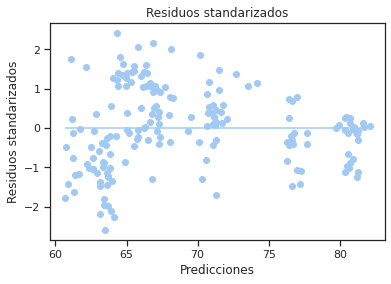

<Figure size 2160x2160 with 0 Axes>

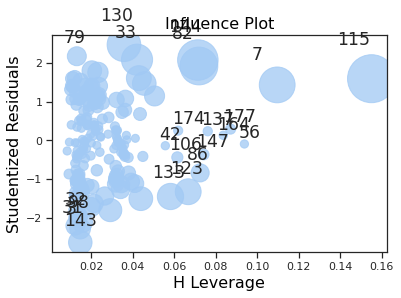

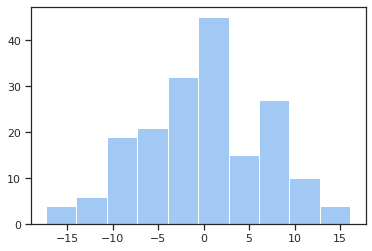

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fd93fd8c9a0>,
 'r2': 0.4694893925077669,
 'rmse': 6.672737449810843,
 'adjusted': 0.4575678058225482,
 'standarized_residuals': 0     -1.285240
 1     -0.207258
 2      1.343622
 3     -2.260539
 4      0.595191
          ...   
 178    0.764228
 179    1.411532
 180   -0.276084
 181   -1.156854
 182   -1.619805
 Name: Life expectancy, Length: 183, dtype: float64,
 'fitted': array([66.76981653, 76.53922965, 64.65311147, 64.10273146, 71.08469846,
        65.50508619, 67.37416501, 72.71795016, 80.70299688, 76.30976861,
        71.66078702, 66.41163039, 65.99790097, 70.81270938, 77.27310321,
        81.00038364, 71.29045354, 63.43895439, 66.2250475 , 66.63286819,
        76.75128003, 61.20706633, 67.02285179, 64.53618558, 80.33417623,
        63.70004203, 62.38370954, 64.05500234, 65.16560079, 63.13856652,
        74.1531841 , 63.14017685, 63.6818262 , 65.81878384, 66.61583626,
        68.06720235, 61.71036161, 

In [77]:
run_analysis(['Latitude', 'Longitude', 'Status_Float', 'Continente_Nro'], df_new)

### Vemos como el R2 va en aumento. Finalizemos agregando el gasto por pais, esto seguro nos dara un mayor contexto. Mezclando no solo la geografia de los paises sino tambien las finanzas, estos atributos van de la mano con el 'Status' de un pais.

In [80]:
df_new[f'Normalizado_Gasto'] = (df_new['percentage expenditure']-np.mean(df_new['percentage expenditure']))/np.std(df_new['percentage expenditure'])

VIF for Latitude 2.170644487790853
VIF for Longitude 1.0607034399617454
VIF for Status_Float 2.5011692207532494
VIF for Continente_Nro 2.678009108040132
VIF for Normalizado_Gasto 1.4926717967118235
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     37.60
Date:                Tue, 09 Nov 2021   Prob (F-statistic):           3.65e-26
Time:                        18:10:33   Log-Likelihood:                -598.78
No. Observations:                 183   AIC:                             1210.
Df Residuals:                     177   BIC:                             1229.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
            

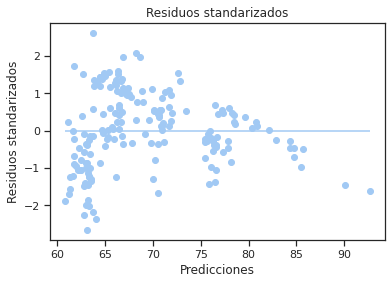

<Figure size 2160x2160 with 0 Axes>

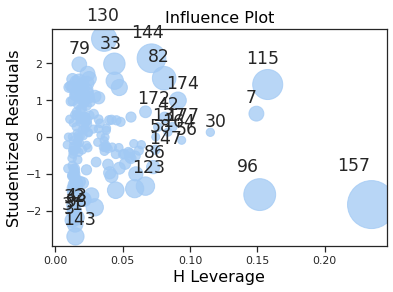

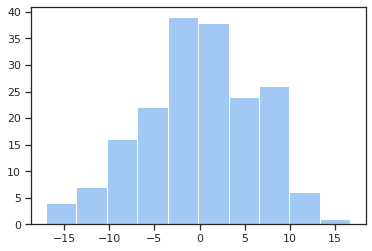

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fd93fac8520>,
 'r2': 0.5150821485564172,
 'rmse': 6.379565301636579,
 'adjusted': 0.5013839041653556,
 'standarized_residuals': 0     -1.249540
 1     -0.092873
 2      1.432671
 3     -2.354974
 4      0.476423
          ...   
 178    0.891959
 179    1.548386
 180   -0.211584
 181   -1.215891
 182   -1.689730
 Name: Life expectancy, Length: 183, dtype: float64,
 'fitted': array([66.16527454, 75.74873741, 64.47892952, 64.04245959, 72.01687823,
        66.65510737, 66.84581222, 77.99060301, 84.35711507, 75.43972985,
        70.81163335, 66.8287949 , 65.4996344 , 70.74843886, 76.59595631,
        80.31474261, 71.1232257 , 63.12775129, 65.86494088, 66.29846069,
        75.96622426, 61.72611393, 67.28633286, 66.36456525, 76.28490893,
        63.36351166, 62.17766236, 63.90276127, 64.79355121, 62.87124949,
        80.8778151 , 62.86334184, 63.30706282, 66.92689966, 66.08621843,
        68.38818969, 61.65853355, 

In [81]:
run_analysis(['Latitude', 'Longitude', 'Status_Float', 'Continente_Nro', 'Normalizado_Gasto'], df_new)

### A ver como se comportan los paises de status 'Developing'?

## Modelo - Developing

In [86]:
df_developing = df_new[df_new['Status'] == 'Developing']

<AxesSubplot:xlabel='Continente', ylabel='Life expectancy'>

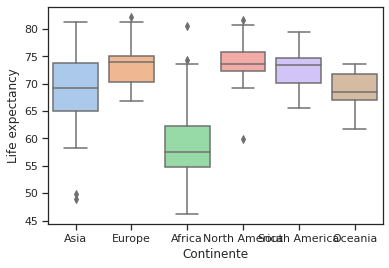

In [91]:
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(x="Continente", y="Life expectancy", data=df_developing)

VIF for Latitude 2.1184585408091157
VIF for Longitude 1.0444746737724804
VIF for Continente_Nro 2.0640936873190463
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     49.77
Date:                Tue, 09 Nov 2021   Prob (F-statistic):           1.92e-23
Time:                        19:15:16   Log-Likelihood:                -609.50
No. Observations:                 183   AIC:                             1227.
Df Residuals:                     179   BIC:                             1240.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------

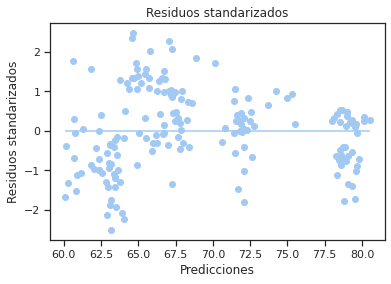

<Figure size 2160x2160 with 0 Axes>

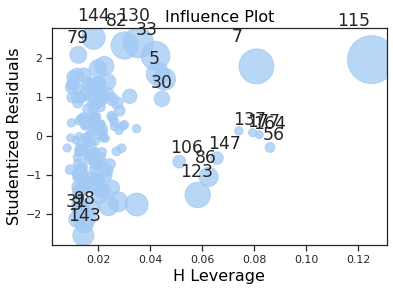

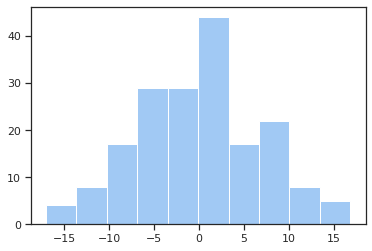

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fd93fba7790>,
 'r2': 0.4548010673472779,
 'rmse': 6.7644812855221925,
 'adjusted': 0.44566365506818195,
 'standarized_residuals': 0     -1.336234
 1     -0.493801
 2      1.337573
 3     -2.220699
 4      0.466468
          ...   
 178    0.702848
 179    1.336116
 180   -0.310466
 181   -1.076117
 182   -1.525736
 Name: Life expectancy, Length: 183, dtype: float64,
 'fitted': array([67.23268271, 78.49655976, 64.57076384, 64.04062581, 71.90083925,
        65.45326749, 67.86479758, 70.17157553, 79.00888231, 78.31600126,
        72.51792321, 66.77949114, 66.42367337, 71.59625327, 79.36056553,
        79.32145996, 72.05590233, 63.17859447, 66.68519685, 66.74133142,
        78.73333604, 60.68854822, 67.217635  , 64.82401694, 78.62151712,
        63.46478808, 62.05345061, 63.80543856, 65.51567522, 62.86383546,
        75.31440431, 62.89255502, 63.50664607, 65.79147528, 67.17586021,
        68.36240943, 61.32517643

In [96]:
run_analysis(['Latitude', 'Longitude', 'Continente_Nro'], df_new)